# Product Demand Forecasting
This is a Time Series Forecasting practice with ARIMA. The goal here is to use historical product data to forecast the demand in the future.

Reference: https://www.kaggle.com/kashdotten/forecast-order-demand-seasonalarima

In [1]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from scipy.stats import norm, skew
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX

## 1. Load data and cleaning
Let's load the data file and check the shape and types of data we have.

In [2]:
df = pd.read_csv('Historical-Product-Demand.csv', parse_dates=['Date'])
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [3]:
df.shape

(1048575, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 40.0+ MB


Check for NaN values. Only 1 column has NaN values, and they account for only 1% of the data. It is safe to drop these.

In [5]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), '/', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), '/', len(df))

1 / 5
11239 / 1048575


In [6]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True)
df.sort_values('Date')

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250
...,...,...,...,...,...
1009604,Product_1710,Whse_J,Category_026,2017-01-06,15
921328,Product_1359,Whse_J,Category_019,2017-01-06,100000
908447,Product_0250,Whse_C,Category_007,2017-01-09,148
863020,Product_1904,Whse_C,Category_019,2017-01-09,4000


In [7]:
df['Order_Demand'] = df['Order_Demand'].str.strip('()')
df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [8]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [9]:
#Lets start with 2012 and cap it 2016 december. Since the dates before 2012 have a lot of missing values - inspected and checked using basic time series plot.
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

## 2. Exploratory Data Analysis
We first explore the features individually, starting with warehouse. Here we sort the warehouses by shipment counts.

In [10]:
df['Warehouse'].value_counts().sort_values(ascending = False)

Whse_J    764215
Whse_A    142197
Whse_S     88024
Whse_C     42207
Name: Warehouse, dtype: int64

Here we sort the warehouses by sum of orders. Warehouse J ships the most orders, while warehouse S ships more orders in fewer shipments.

In [11]:
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)

,Order_Demand
Warehouse,
Whse_J,3362742530
Whse_S,1033121811
Whse_C,582004179
Whse_A,147646550


We then look at the product category feature. There are 33 categories. From the count plot, category 19 has the most orders.

In [12]:
print(df['Product_Category'].unique())
print(len(df['Product_Category'].unique()))

['Category_024' 'Category_001' 'Category_019' 'Category_006'
 'Category_021' 'Category_011' 'Category_032' 'Category_030'
 'Category_005' 'Category_031' 'Category_026' 'Category_028'
 'Category_015' 'Category_007' 'Category_009' 'Category_004'
 'Category_022' 'Category_023' 'Category_018' 'Category_020'
 'Category_013' 'Category_003' 'Category_010' 'Category_008'
 'Category_033' 'Category_017' 'Category_029' 'Category_025'
 'Category_012' 'Category_014' 'Category_002' 'Category_027'
 'Category_016']
33


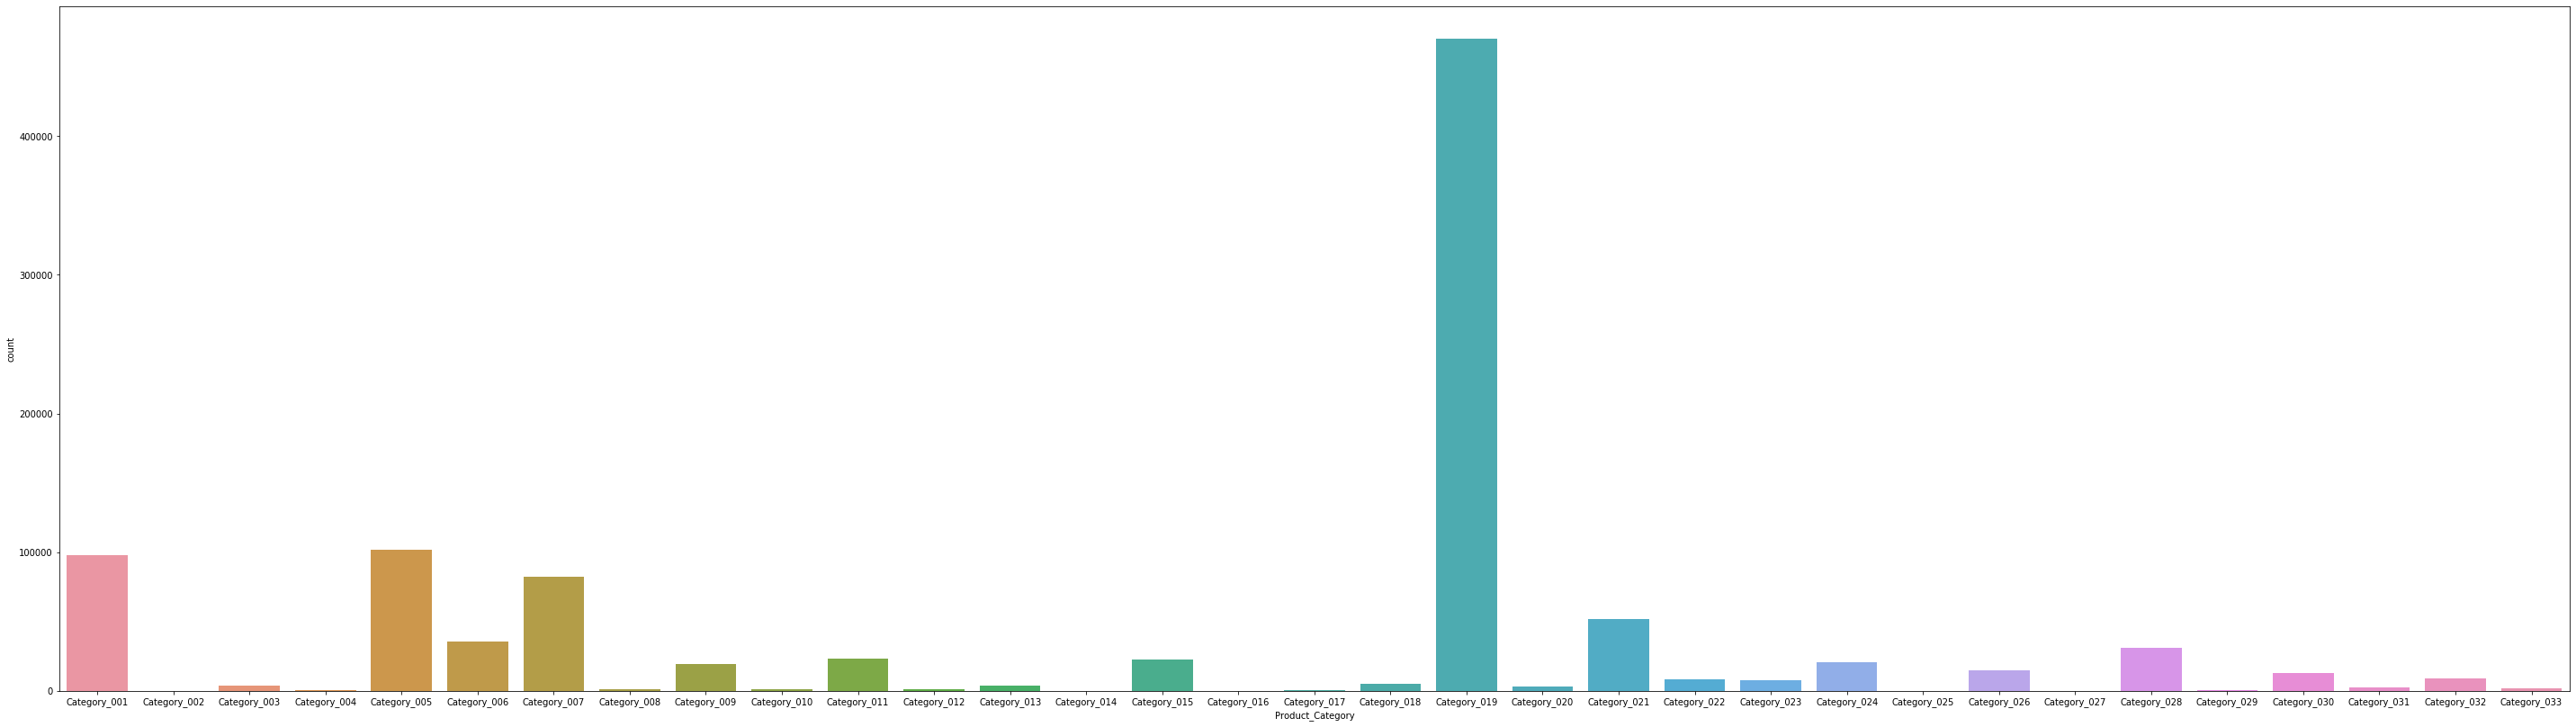

In [13]:
rcParams['figure.figsize'] = 50,14
sns.countplot(df['Product_Category'].sort_values(ascending = True))

Now let's see how these features interact with the order demand. Again, we start with the warehouse feature.

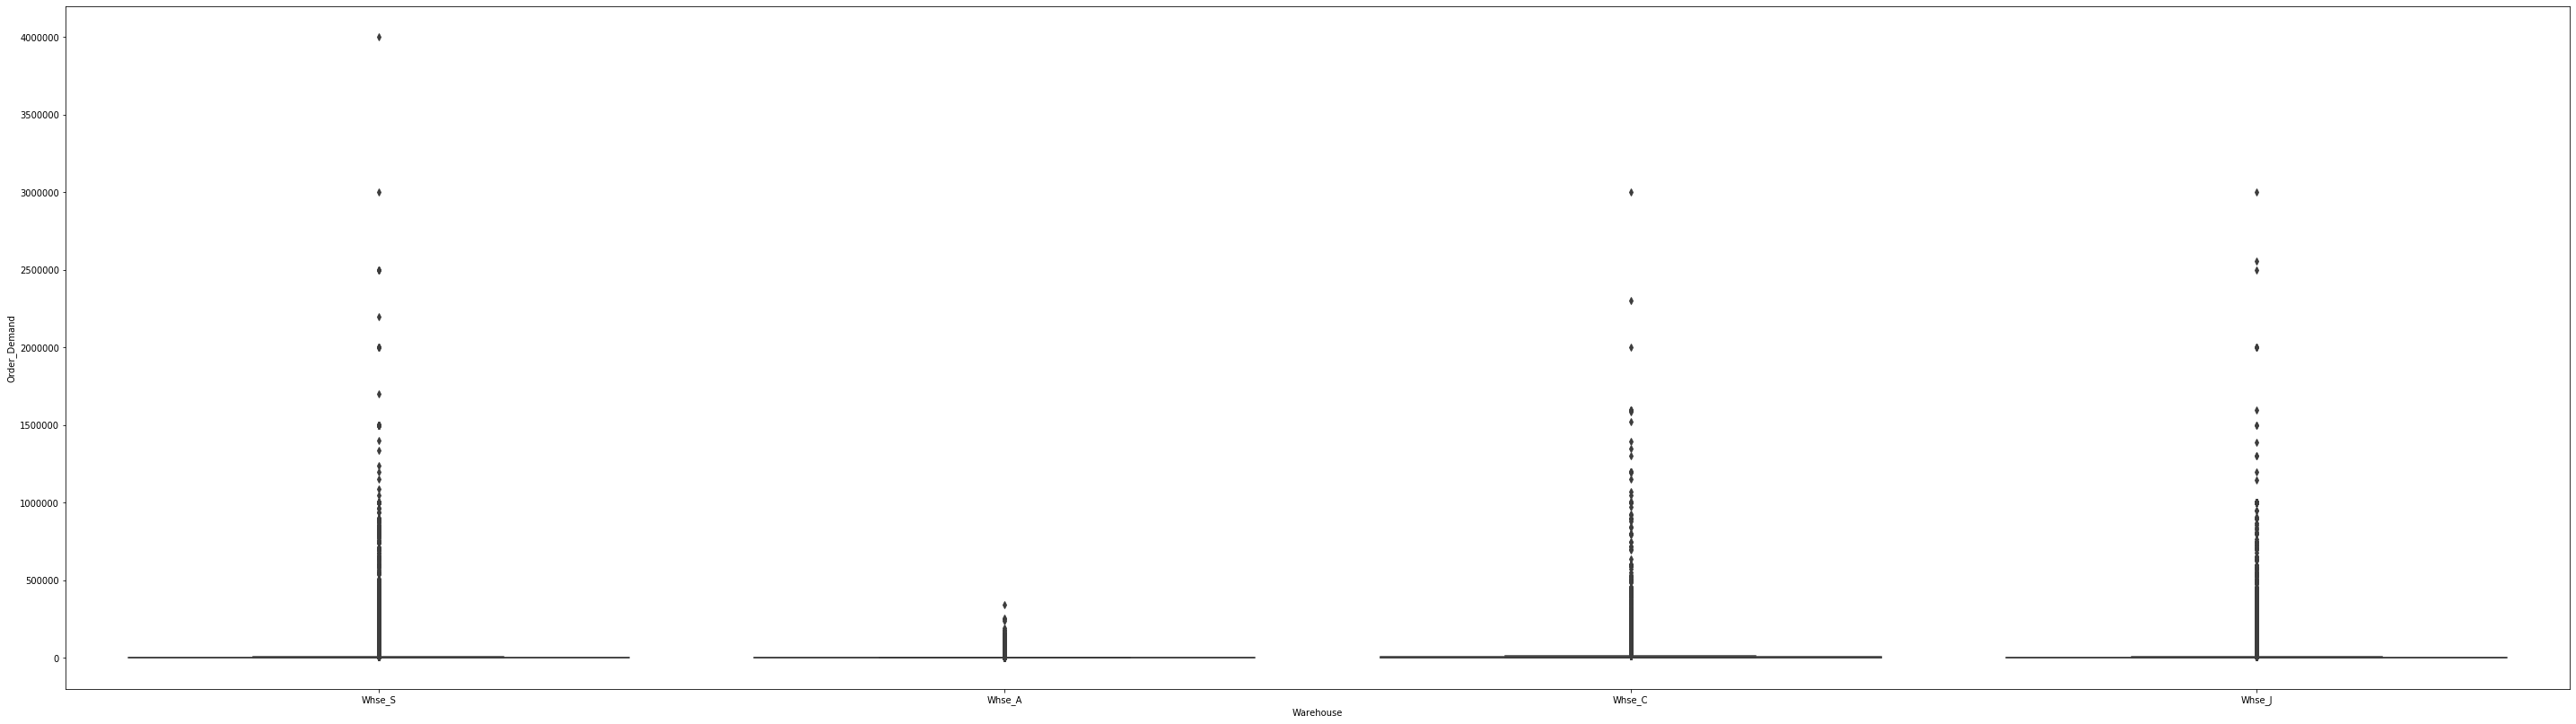

In [14]:
sns.boxplot(df['Warehouse'],df['Order_Demand'])

Where are the boxes? Let's apply a log transformation to the order demand feature.

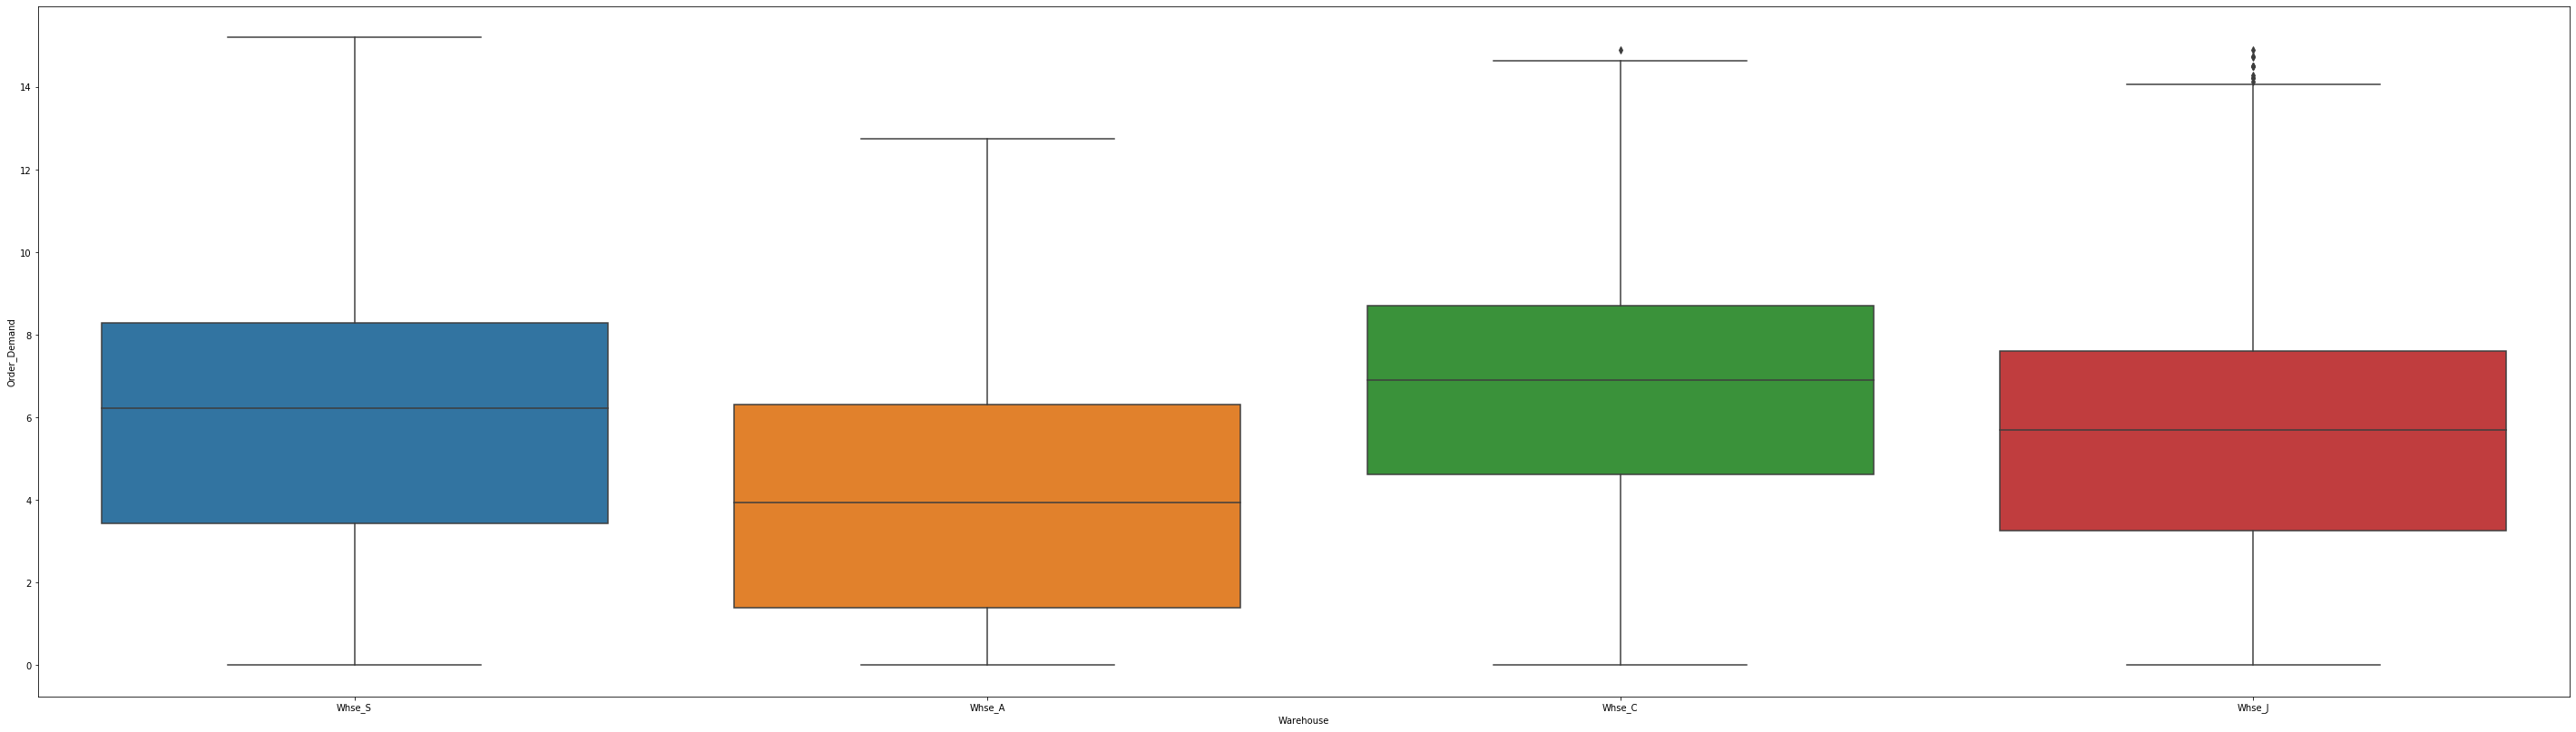

In [15]:
sns.boxplot(df['Warehouse'], np.log1p(df['Order_Demand']))

Now with product category, we sample a subset of data to deal with the memory issue. Again, we apply a log transformation to the order demand feature.

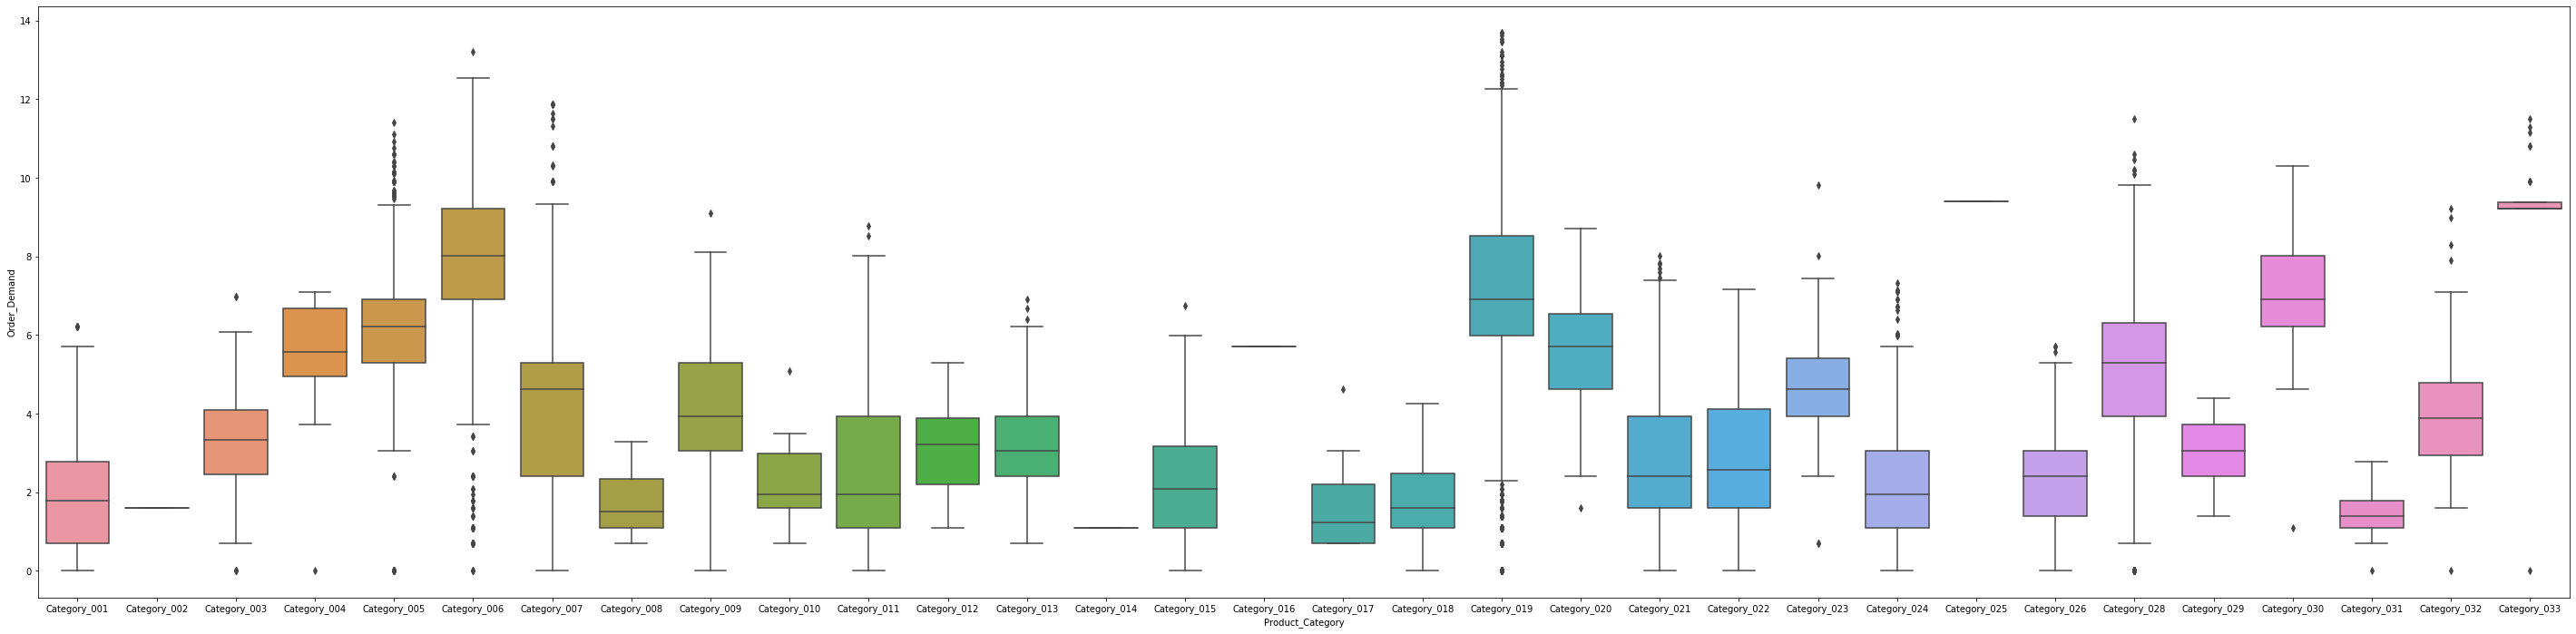

In [16]:
rcParams['figure.figsize'] = 50,12
df_temp = df.sample(n=20000).reset_index()
fig5 = sns.boxplot( df_temp['Product_Category'].sort_values(),np.log1p(df_temp['Order_Demand']))

## 3. Time series analysis
We can first sum the total order demand for each day.

In [28]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
df.head()

,Date,Order_Demand
0,2012-01-01,2
1,2012-01-02,680277
2,2012-01-03,1645257
3,2012-01-04,1295861
4,2012-01-05,8941774


We use the date as index here for resampling later.

In [18]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

Let's average daily order demand for each month.

In [19]:
y = df['Order_Demand'].resample('MS').mean()

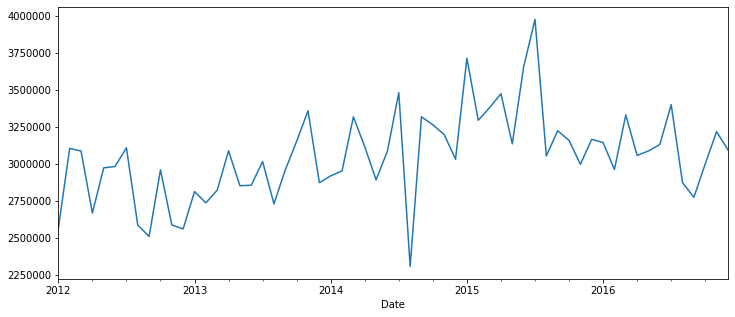

In [20]:
y.plot(figsize=(12,5))
plt.show()

We can use statsmodels' time series analysis library to decompose our data into additive components. 4 plots are shown below, with the top one being the original time series. The data is decomposed into 3 components here: Trend, seasonal, and residual. 

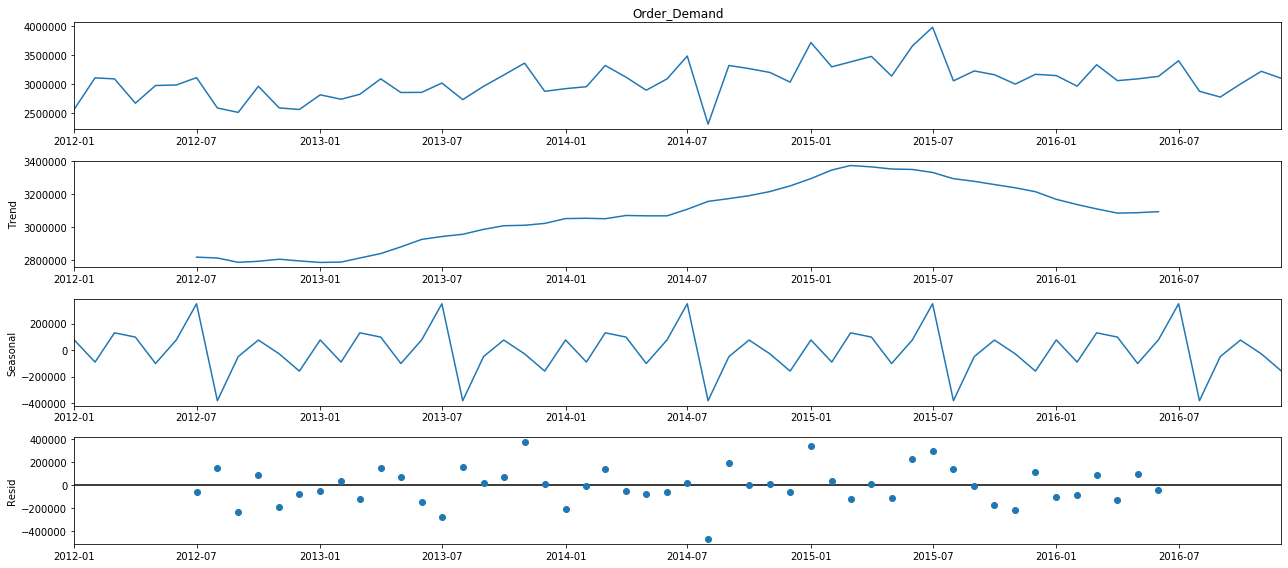

In [21]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

SARIMA: Seasonal Autoregressive Integrated Moving Average.\
The terms are AR: autoregression. I: differencing. MA: moving average.

12 is for monthly data.

More information can be found in this quick start [tutorial](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/) and gridsearch SARIMA [tutorial](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/).
Documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX). 

In [22]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Below is a manual gridsearch over the parameters for seasonal arima. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. AIC measures how well a model fits the data while taking into account the overall complexity of the model. Large AIC: Model fits very well using a lot of features. Small AIC: Model fits similar fit but using lesser features. Hence the lower the AIC, the better it is.

In [23]:
#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.927583212436
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3023.482324073208
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457734
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859485
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3064.958350052849
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.087487804522
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700691
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345486
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2942.2244097097573
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650718
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277853
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759119
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3009.0925627524493
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC

The next iteration of this method would involve using a pre-built gridsearch pipeline like the one in scikit-learn.\
The best parameters from this round are found to be:\
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:960.56

We use these parameters in SARIMA.

In [24]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


Let's plot the diagnostics.

What should we expect?

1. The residuals should be normally distributed. Top right: the orange KDE line should closely match the green N(0,1) (normal distribution with zero mean and unit variance) line. Bottom left: the qq plot shows the ordered distribution of residuals which follows the linear trend of samples taken from N(0,1).

2. The residuals are not correlated. Top left: the standardized residuals do not display seasonality and appear to be noise. Bottom right: the autocorrelation (correlogram) plot shows that the time series residuals have low correlation with irs own lagged versions.

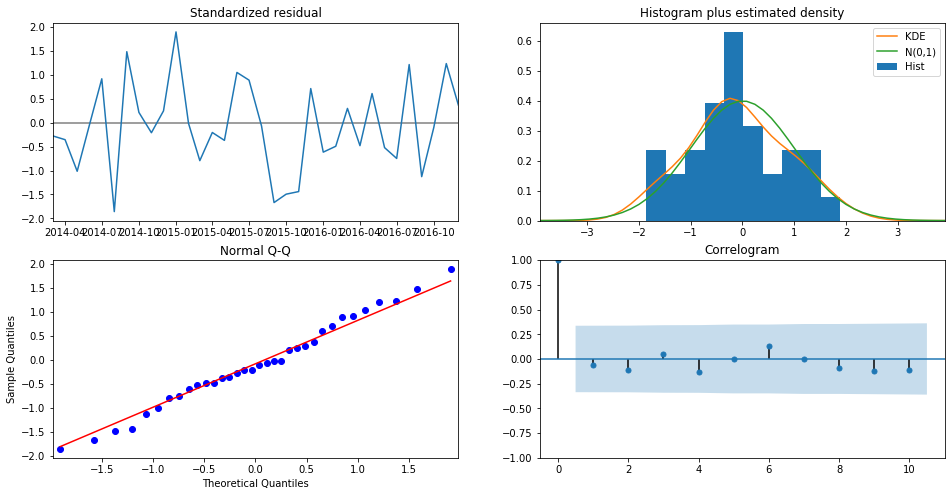

In [25]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## 4. Validation
We can use a subset of the data to validate our time series model. Here we can choose the data starting from April 2015. Here we see the prediction seems to fit well with the observed data. The confidence interval defaults to 95%.

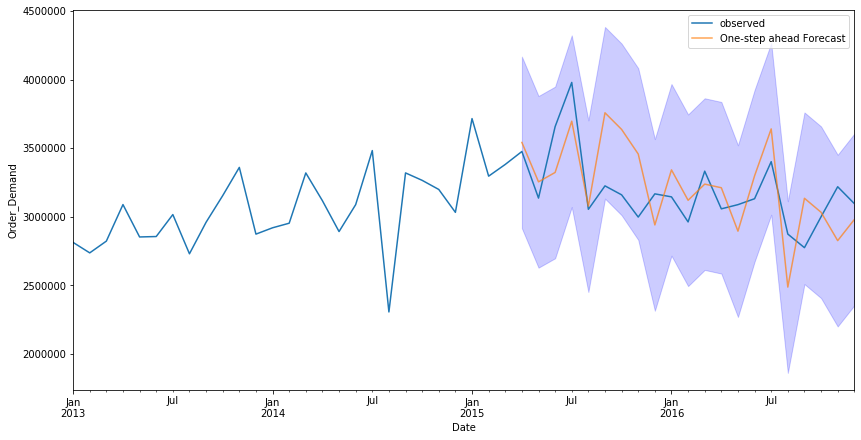

In [34]:
pred = results.get_prediction(start=pd.to_datetime('2015-04-01'), dynamic=False) #false is when using the entire history.
pred_ci = pred.conf_int()

ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

## 5. Forecasting
Now we would like to forecast order demands for the next 50 months. As expected, the further ahead in time, the more variance is expected from the prediction. 

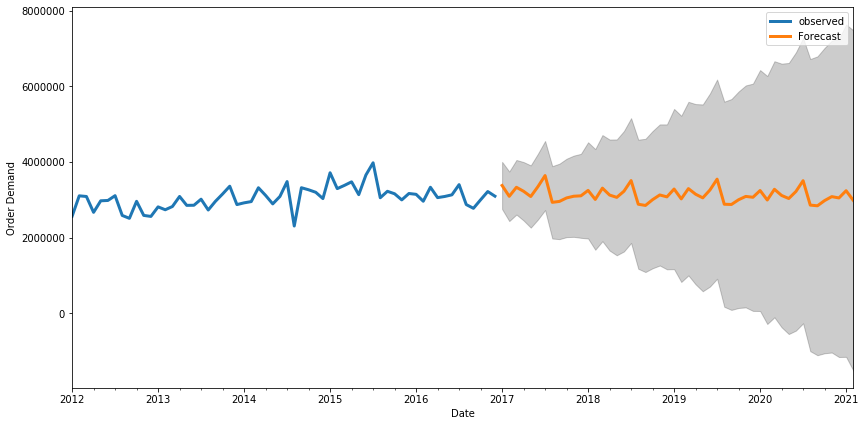

In [27]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7), linewidth=3)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', linewidth=3)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order Demand')
plt.legend()
plt.show()